Encoder Decoder LSTM With logcosh

In [1]:
# Autoreload
%load_ext autoreload
%autoreload

In [2]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils, generators, models
%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed

from scipy.stats import pearsonr

In [3]:
train_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_paths[0])[1]
# Electrodes
electrode_count = 1
electrode = 5
lookback = 100
pred_length = 20
# Training Generator
train_generator = generators.FGenerator(file_paths=train_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=True,
                                        teacher_forcing=True,
                                        teacher_forcing_concat=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False,
                                        teacher_forcing=True,
                                        teacher_forcing_concat=True)

(5429, 114)


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':20})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 16)     32          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 32)     1056        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     1056        conv1d[0][0]                     
______________________________________________________________________________________________

In [6]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=2,
#             mode="min"
#         )
]
history = model.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=100,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 4 steps
Epoch 1/100
12/12 [==============================] - 17s 1s/step - loss: 0.6861 - val_loss: 0.5718
Epoch 2/100
12/12 [==============================] - 6s 531ms/step - loss: 0.5448 - val_loss: 0.5006
Epoch 3/100
12/12 [==============================] - 6s 517ms/step - loss: 0.5084 - val_loss: 0.4904
Epoch 4/100
12/12 [==============================] - 6s 533ms/step - loss: 0.4998 - val_loss: 0.4874
Epoch 5/100
12/12 [==============================] - 6s 519ms/step - loss: 0.4965 - val_loss: 0.4859
Epoch 6/100
12/12 [==============================] - 6s 517ms/step - loss: 0.4942 - val_loss: 0.4849
Epoch 7/100
12/12 [==============================] - 7s 567ms/step - loss: 0.4932 - val_loss: 0.4847
Epoch 8/100
12/12 [==============================] - 7s 574ms/step - loss: 0.4928 - val_loss: 0.4843
Epoch 9/100
12/12 [========

In [4]:
from tensorflow.keras.models import model_from_json

file_name = "models/wavenet_o2o"
# serialize model to JSON
model_json = model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"{file_name}.h5")


NameError: name 'model' is not defined

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

NameError: name 'history' is not defined

In [4]:
from tensorflow.keras.models import model_from_json

file_name = "models/wavenet_o2o"
# load json and create model
json_file = open(f'{file_name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(f"{file_name}.h5")
print("Loaded model from disk")

Loaded model from disk


In [5]:
def predict_sequence_o2o(input_sequence, pred_steps, model):
    lookback = input_sequence.shape[1]
#     print(input_sequence.shape)
    history_sequence = input_sequence.reshape((1, lookback, 1))
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)
        last_step_pred = last_step_pred.reshape(-1)

        pred_sequence[i] = last_step_pred[-1]
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           last_step_pred[-1].reshape(1, 1, 1)], axis=1)

    return pred_sequence

In [6]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int, enc_tail_len=100):
    encode_series = encoder_input_data[sample_ix:sample_ix+1,:,:] 
    pred_series = predict_sequence_o2o(encode_series,
                                              pred_steps, model)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    print(f"Correlation: {r}. P: {p}. Mae: {mae}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [7]:
val_batch = val_generator[0]

In [8]:
len(val_batch[0][0])

119

Correlation: 0.0138039291258064. P: 0.9539393976600021. Mae: 0.5070329583240835


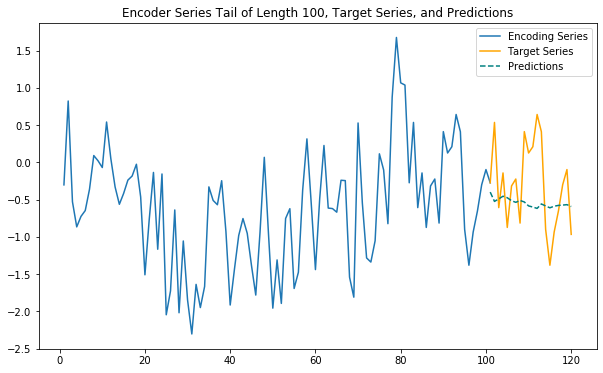

In [9]:
predict_and_plot(val_batch[0], val_batch[1], sample_ix=0, pred_steps=20)

In [9]:
def get_corr_mae(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int,
                 enc_tail_len=100, verbose=True):
    encode_series = encoder_input_data[sample_ix:sample_ix+1,:,:] 
    pred_series = predict_sequence_o2o(encode_series,
                                              pred_steps, model)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [11]:
encoder_input_data = val_batch[0]
encoder_target_data = val_batch[1]

In [12]:
n_rows = int(encoder_input_data.shape[0]//2)
r_array = np.empty(shape=(n_rows,))
z_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data, encoder_target_data, sample_ix=sample_ix, pred_steps=20, verbose=False)
    r_array[sample_ix] = r
    z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
    sample_maes[sample_ix] = mae
z_mean = np.mean(z_array)
batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Absolute Batch_r: {np.mean(np.abs(r_array))}")
print(f"Batch Mae: {batch_mae}")

Batch_r: -0.15857562005568654
Absolute Batch_r: 0.29164985394677945
Batch Mae: 0.5478843753675652


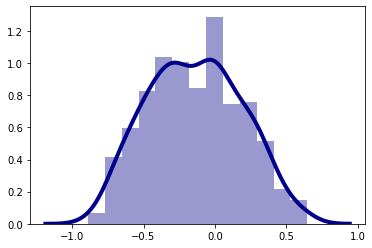

In [13]:

# Plot the distribution of r
import seaborn as sns
sns.distplot(r_array, kde=True, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [14]:
k = 5
top_k_r = np.abs(r_array).argsort()[-k:]
print(top_k_r)

[217 399 456 166 133]


Correlation: -0.7625895948774946. P: 9.253734530067356e-05. Mae: 1.3544275693711838
Correlation: -0.8147837738959216. P: 1.2171319247330322e-05. Mae: 1.0170780626907634
Correlation: -0.8295491890217825. P: 6.102911744799588e-06. Mae: 0.8914224837276338
Correlation: -0.8362645742455777. P: 4.362235372861097e-06. Mae: 0.5383035521274555
Correlation: -0.8895641829616636. P: 1.5444564737438668e-07. Mae: 0.8546971547659277


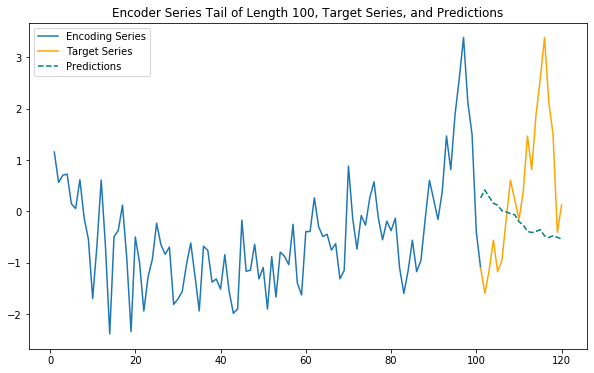

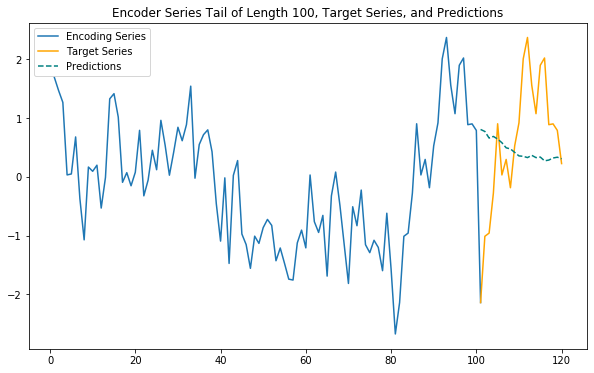

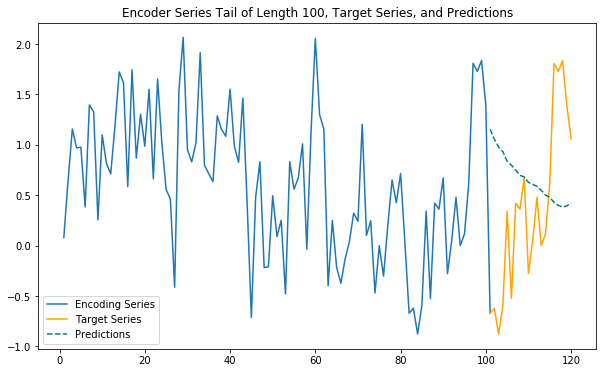

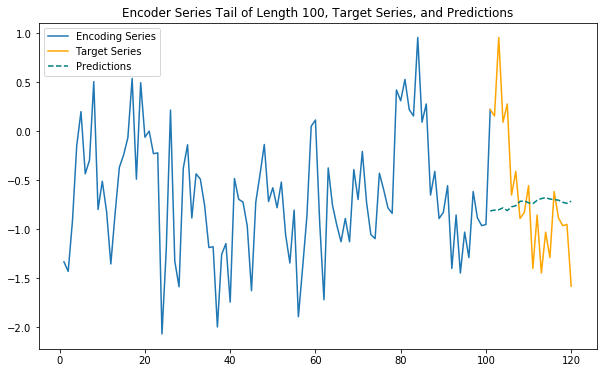

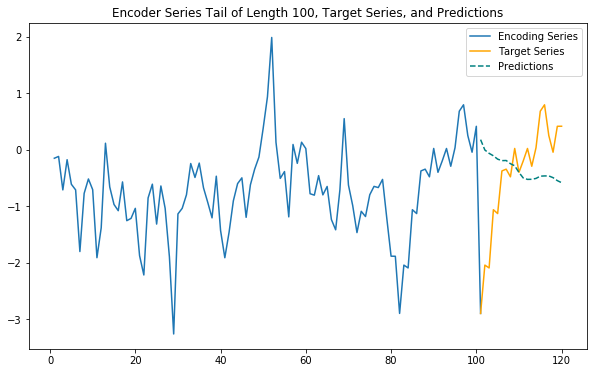

In [15]:
for i in top_k_r:
    predict_and_plot(val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=20)

In [16]:
k = 5
top_k_mae = sample_maes.argsort()[:k]
print(top_k_mae)

[110 188 477 357 482]


Correlation: -0.24711564762298827. P: 0.29354442070992914. Mae: 0.2304371587369793
Correlation: -0.3063425769503172. P: 0.1889664491081457. Mae: 0.253710827719163
Correlation: 0.3062714568658088. P: 0.18907440349423033. Mae: 0.2775869420060684
Correlation: 0.15846275363504958. P: 0.5045982216390508. Mae: 0.301375494114988
Correlation: 0.5396900410269498. P: 0.014047438270333312. Mae: 0.30581887229043625


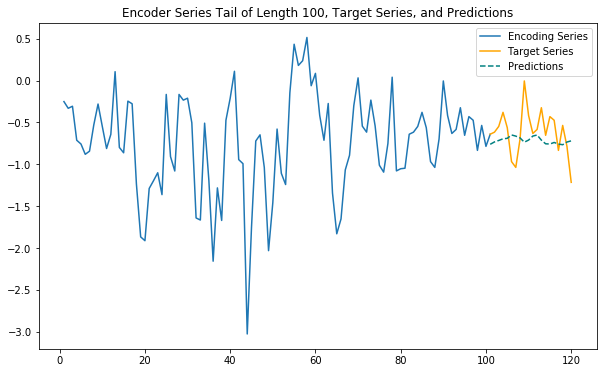

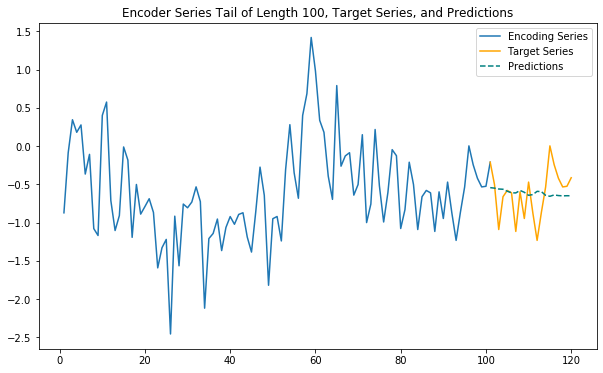

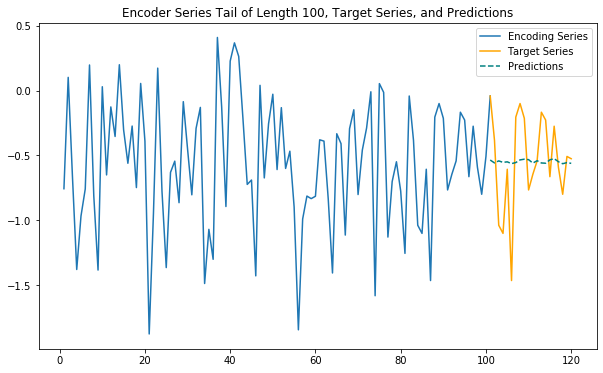

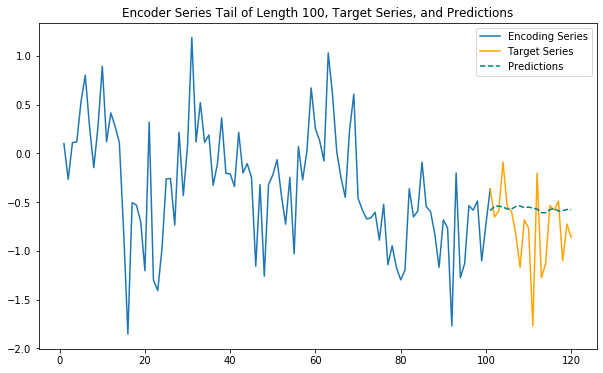

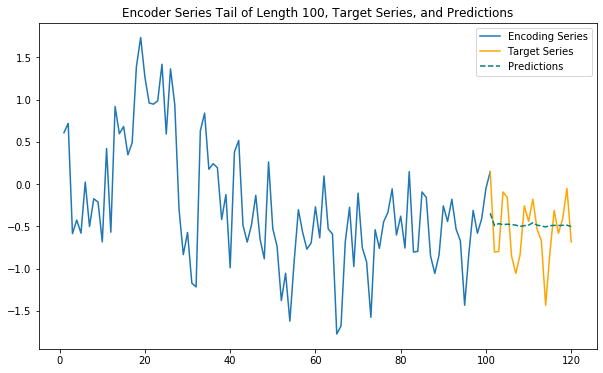

In [17]:
for i in top_k_mae:
    predict_and_plot(val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=20)

In [10]:
def predict_sequence_o2o_window(input_sequence, pred_steps, model, lookback=lookback):
    history_sequence = input_sequence.reshape((1, lookback, 1))
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)
        last_step_pred = last_step_pred.reshape(-1)

        pred_sequence[i] = last_step_pred[-1]
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           last_step_pred[-1].reshape(1, 1, 1)], axis=1)

    return pred_sequence

def moving_window_pred_o2o(input_sequence,
                           lookback,
                           pred_steps,
                           electrode_count,
                           model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], electrode_count))
    print(final_array.shape)
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end] = input_sequence[w_start : w_end]
    while w_end + pred_steps < input_sequence.shape[0]:
        window_lookback = input_sequence[w_start: w_end]
        pred_seq = predict_sequence_o2o_window(window_lookback, pred_steps, model, lookback=lookback)
        final_array[w_end:w_end+pred_steps] = pred_seq.reshape(pred_steps, electrode_count)
        w_start += pred_steps
        w_end += pred_steps
    return final_array

def get_corr_mae_conv(input_seq,
                      lookback,
                      pred_length,
                      electrode_count,
                      electrode,
                      model,
                      enc_tail_len=100,
                      verbose=True):
    
    
    input_seq = input_seq[:,electrode].reshape(input_seq.shape[0], electrode_count)

    predicted_series = moving_window_pred_o2o(input_seq,
                                              lookback = lookback,
                                              pred_steps = pred_length,
                                              electrode_count=electrode_count,
                                              model=model)
    
    input_seq = input_seq[lookback:,:]

    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

def get_corr_mae_conv_step(input_seq,
                           lookback,
                           k,
                           pred_length,
                           electrode_count,
                           electrode,
                           model,
                           enc_tail_len=100,
                           verbose=True):
    
    
    input_seq = input_seq[:,electrode].reshape((input_seq.shape[0], electrode_count))

    predicted_series = moving_window_pred_o2o_step(input_seq,
                                                   lookback = lookback,
                                                   k=k,
                                                   pred_steps = pred_length,
                                                   electrode_count=electrode_count,
                                                   model=model)
    
    input_seq = input_seq[lookback:,:]

    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

def moving_window_pred_o2o_step(input_sequence,
                                lookback,
                                pred_steps,
                                k,
                                electrode_count,
                                model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], electrode_count))
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end + k, :] = input_sequence[w_start : w_end + k, :]
    print(final_array.shape)
    full_length = int(len(input_sequence))
    print(full_length)
    i = w_end + k
    while i < full_length:
        window_lookback = np.array([input_sequence[w_start: w_end]])
#         print(window_lookback.shape)
        pred_steps = model.predict(window_lookback)
#         print(pred_steps.reshape((20, 1)))
#         print(pred_steps.shape)
        final_array[w_end + k] = pred_steps[:,k,:].reshape((1, 1))
        w_end += 1
        w_start += 1
        i += 1
    return final_array

In [11]:
data = np.load(val_paths[0])

(2048, 1)
Correlation: 0.5118264007489092. P: 1.5336293478718047e-130. MAE: 0.6034965105285441


(0.5118264007489092, 0.6034965105285441)

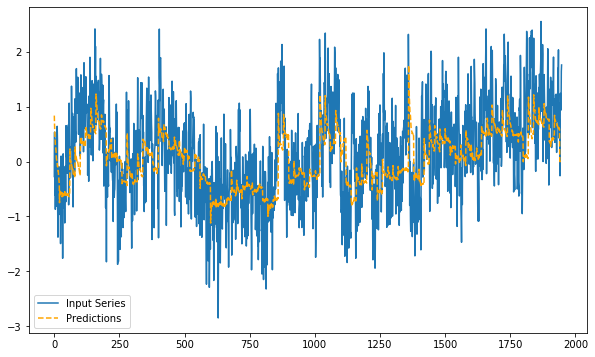

In [21]:
get_corr_mae_conv(data[:2048,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(1100, 1)
Correlation: 0.504999964991069. P: 7.878311145714187e-66. MAE: 0.5729867306750281


(0.504999964991069, 0.5729867306750281)

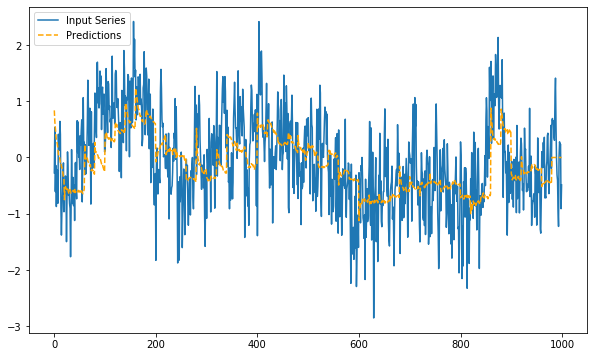

In [18]:
get_corr_mae_conv(data[:1100,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(200, 1)
200
Correlation: 0.2782386283011628. P: 0.005063288153899253. MAE: 0.677717923085976


(0.2782386283011628, 0.677717923085976)

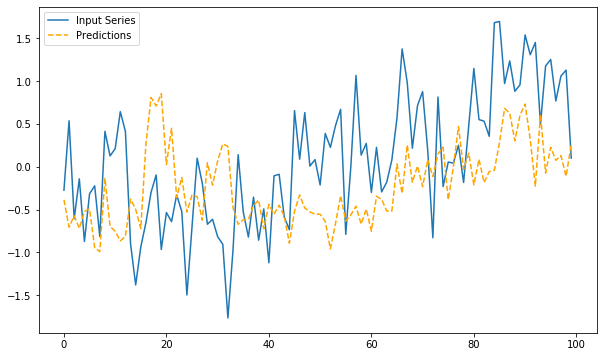

In [22]:
get_corr_mae_conv_step(data[:200,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

(2048, 1)
2048
Correlation: 0.3649089243092079. P: 2.0370464436187367e-62. MAE: 0.6815471275803784


(0.3649089243092079, 0.6815471275803784)

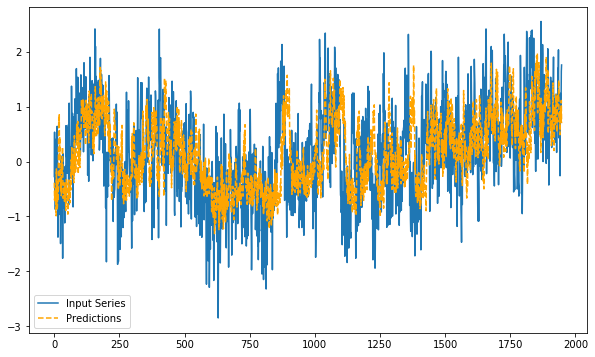

In [18]:
get_corr_mae_conv_step(data[:2048,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

(2048, 1)
2048
Correlation: 0.3661349740839044. P: 7.419967876887833e-63. MAE: 0.6808083395059783


(0.3661349740839044, 0.6808083395059783)

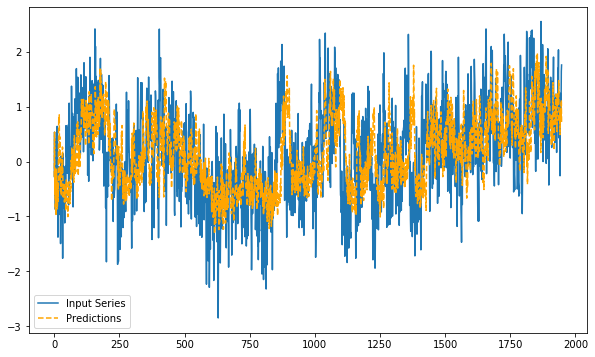

In [19]:
get_corr_mae_conv_step(data[:2048,:], lookback, 5, pred_length, electrode_count=1, electrode=electrode, model=model)

(2048, 1)
2048
Correlation: 0.3663345119554309. P: 6.292735511432252e-63. MAE: 0.679855623262364


(0.3663345119554309, 0.679855623262364)

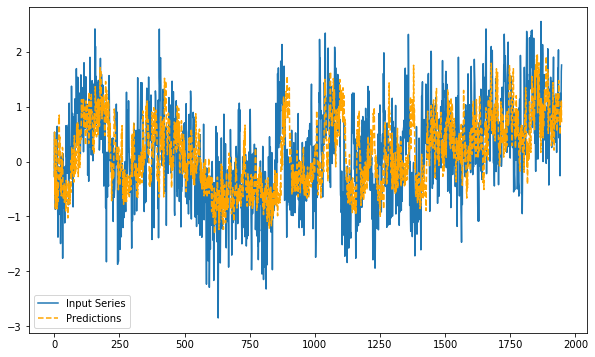

In [20]:
get_corr_mae_conv_step(data[:2048,:], lookback, 10, pred_length, electrode_count=1, electrode=electrode, model=model)

# TEST DATA

In [13]:
test_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/test_676_bin_norm_2.txt")

In [14]:
test_paths[0]

'/projects/HASSON/247/data/binned_conversations/676_bin_norm_2/bin_norm_2_NY676_618_Part5-one_conversation1/bin_norm_2_NY676_618_Part5-one_conversation1.npy'

In [15]:
for path in test_paths:
    utils.get_file_shape(path)

(163846, 114)
(102096, 114)
(73475, 114)
(33158, 114)
(17795, 114)
(64950, 114)
(92170, 114)
(83951, 114)
(42936, 114)
(21311, 114)


In [16]:
test_data = np.load(test_paths[0])

(2100, 1)
Correlation: 0.3081499770535101. P: 2.975831625286731e-45. MAE: 0.7039452076261645


(0.3081499770535101, 0.7039452076261645)

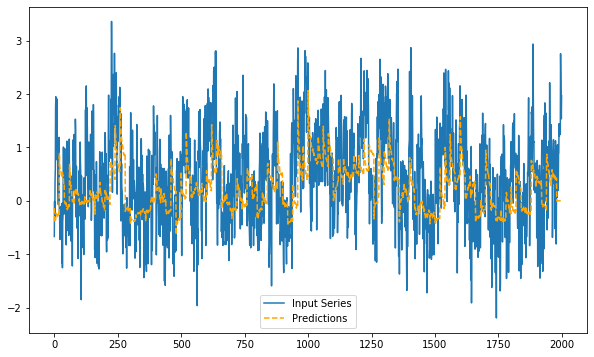

In [27]:
get_corr_mae_conv(test_data[:2100,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(250, 1)
Correlation: 0.3234910197581726. P: 5.392856867660109e-05. MAE: 0.6280222680628138


(0.3234910197581726, 0.6280222680628138)

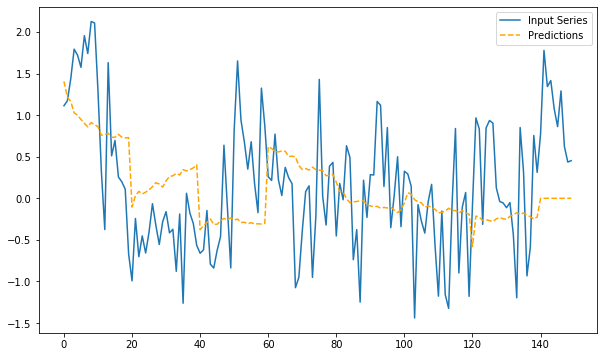

In [28]:
get_corr_mae_conv(test_data[250:500,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(1100, 1)
Correlation: 0.1755683138440026. P: 2.2907093404916247e-08. MAE: 0.7446331211721309


(0.1755683138440026, 0.7446331211721309)

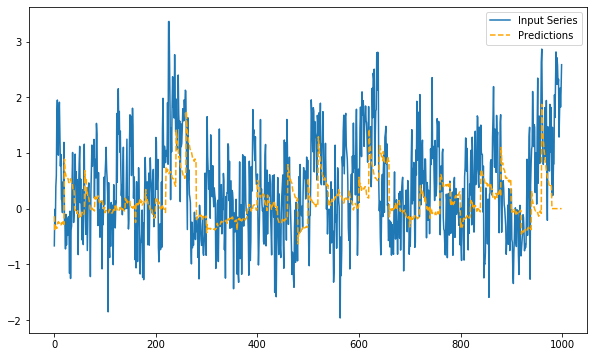

In [17]:
get_corr_mae_conv(test_data[0:1100,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(250, 1)
250
Correlation: -0.16183260035024102. P: 0.04787033128983365. MAE: 0.7686269193593036


(-0.16183260035024102, 0.7686269193593036)

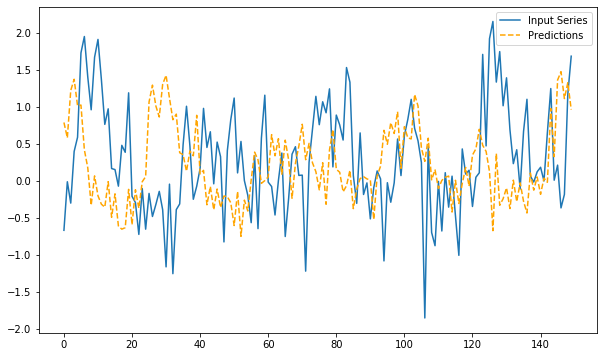

In [30]:
get_corr_mae_conv_step(test_data[:250,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

(2100, 1)
2100
Correlation: 0.13317204819746295. P: 2.251209448564454e-09. MAE: 0.810867029090098


(0.13317204819746295, 0.810867029090098)

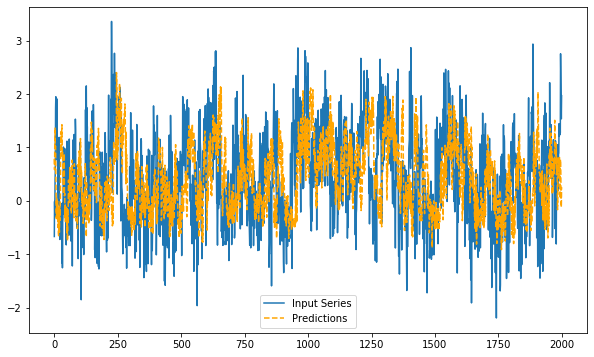

In [31]:
get_corr_mae_conv_step(test_data[:2100,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

(2100, 1)
2100
Correlation: 0.13658825893288137. P: 8.604281968150168e-10. MAE: 0.8084769083391316


(0.13658825893288137, 0.8084769083391316)

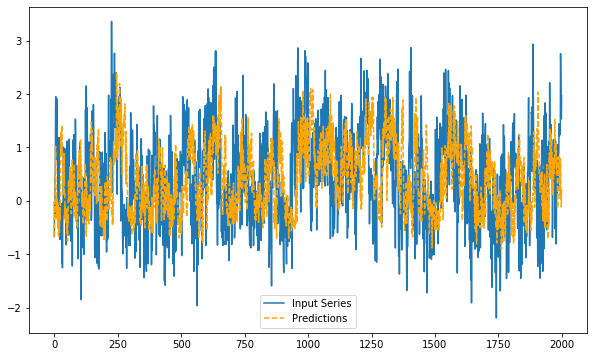

In [32]:
get_corr_mae_conv_step(test_data[:2100,:], lookback, 5, pred_length, electrode_count=1, electrode=electrode, model=model)

(2100, 1)
2100
Correlation: 0.14264175867416784. P: 1.4750158172165791e-10. MAE: 0.8052751659548656


(0.14264175867416784, 0.8052751659548656)

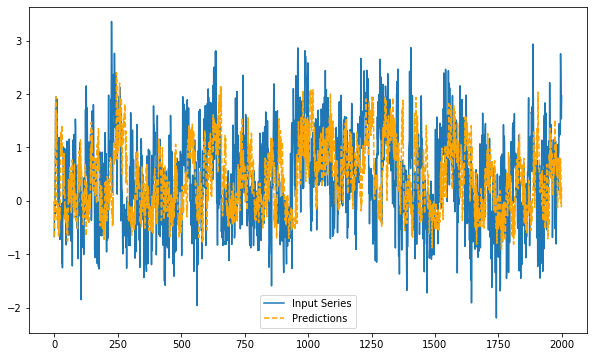

In [33]:
get_corr_mae_conv_step(test_data[:2100,:], lookback, 10, pred_length, electrode_count=1, electrode=electrode, model=model)

(1100, 1)
1100
Correlation: 0.1529003722028881. P: 1.187711397446306e-06. MAE: 0.7970921807578877


(0.1529003722028881, 0.7970921807578877)

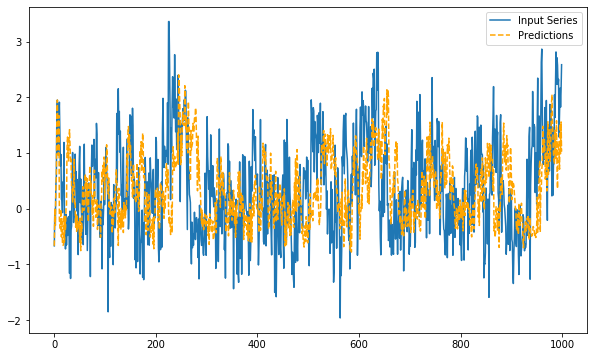

In [34]:
get_corr_mae_conv_step(test_data[:1100,:], lookback, 10, pred_length, electrode_count=1, electrode=electrode, model=model)

In [36]:
# Test_gene
test_generator = generators.FGenerator(file_paths=test_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=2048,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False)

In [37]:
len(test_generator)

2

In [38]:
test_batch = test_generator[0]

In [39]:
encoder_input_data = test_batch[0]
encoder_target_data = test_batch[1]

In [40]:
n_rows = int(encoder_input_data.shape[0]//2)
r_array = np.empty(shape=(n_rows,))
z_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data, encoder_target_data, sample_ix=sample_ix, pred_steps=20, verbose=False)
    r_array[sample_ix] = r
    z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
    sample_maes[sample_ix] = mae
z_mean = np.mean(z_array)
batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Absolute Batch_r: {np.mean(np.abs(r_array))}")
print(f"Batch Mae: {batch_mae}")

Batch_r: 0.08877463006635088
Absolute Batch_r: 0.28210972613329954
Batch Mae: 0.6285527482633009
